In [4]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm

from sklearn.preprocessing import PolynomialFeatures
from utils.numerical_differentiation.tikhonov import TikhonovDifferentiation

from scipy.linalg import lstsq
from scipy.integrate import odeint
from scipy.sparse import tril, eye, coo_matrix
from scipy import interpolate

import pandas as pd

import matplotlib.pyplot as plt

In [5]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def vanderpol(x, t, gamma=1, kappa=1, epsilon=2):
    return [
            x[1],
            -kappa * x[0] - gamma * x[1] - epsilon * x[1] * x[0] ** 2
            ]

gamma=1
kappa=1
epsilon=2

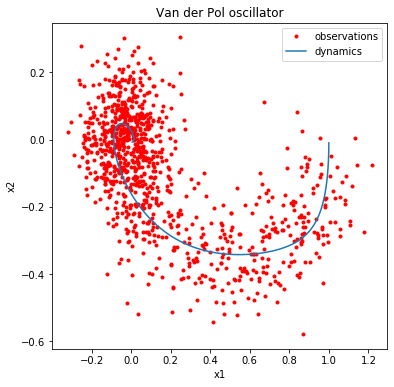

In [8]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [1, 0]
X = odeint(vanderpol, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -kappa * x1 - gamma * x2 - epsilon * x2 * x1 ** 2

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.1
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Van der Pol oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

## Tikhonov regularization differentiation

$\dot{\hat{x}} = \text{argmin} \frac{1}{2} ||\tilde{x} - A\dot{x}||_2^2 + \lambda ||D^{(2)}\dot{x}||_2$

In [9]:
# Tikhonov regularization differentiation

dy_tikdiff = []
error_tikdiff = []
residual_td = []
reg_residual_td = []
gcv_td = []

#Define the array of lambdas
n_lambdas = 100
lambdas_tikdiff = np.logspace(-10,1,n_lambdas)

#Loop over all state variables
for state in range(n_states):

    tik_diff = TikhonovDifferentiation()
    dy_td = tik_diff.fit(t,Y[:,state],lambdas_tikdiff)
    dy_tikdiff.append(dy_td)
    
    error_dy_td = np.zeros(n_lambdas)

    for i, reg_lambda in enumerate(lambdas_tikdiff): 

        error_dy_td[i] = norm(dy_td[:,i] - dX[:,state])/norm(dX[:,state])
        
    error_tikdiff.append(error_dy_td)
    residual_td.append(tik_diff.residual)
    reg_residual_td.append(tik_diff.reg_residual)
    gcv_td.append(tik_diff.gcv)

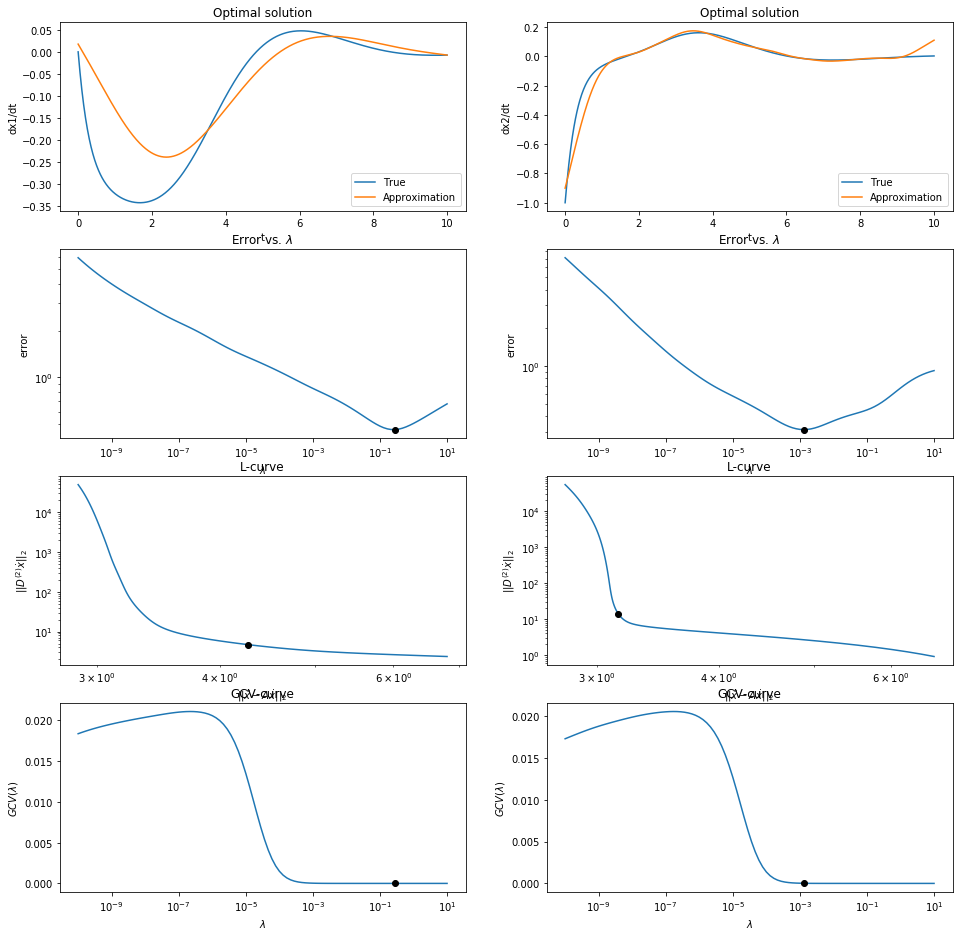

In [10]:
# Compute the lambda that yields the minimum error

fig,axs = plt.subplots(4,n_states,figsize = (16,16))
plt.tight_layout

for state in range(n_states):
    
    lambda_min_indx = np.argmin(error_tikdiff[state])
    
    axs[0,state].plot(t,dX[:,state])
    axs[0,state].plot(t,dy_tikdiff[state][:,lambda_min_indx])
    axs[0,state].set_title('Optimal solution')
    axs[0,state].set_xlabel('t')
    axs[0,state].set_ylabel(f'dx{state+1}/dt')
    axs[0,state].legend(['True','Approximation'])
    
    axs[1,state].loglog(lambdas_tikdiff,error_tikdiff[state])
    axs[1,state].loglog(lambdas_tikdiff[lambda_min_indx],error_tikdiff[state][lambda_min_indx],'ko')
    axs[1,state].set_title('Error vs. $\lambda$')
    axs[1,state].set_xlabel('$\lambda$')
    axs[1,state].set_ylabel('error')
    
    axs[2,state].loglog(residual_td[state],reg_residual_td[state])
    axs[2,state].loglog(residual_td[state][lambda_min_indx],reg_residual_td[state][lambda_min_indx],'ko')
    axs[2,state].set_title('L-curve')
    axs[2,state].set_xlabel(r'$||\tilde{x} - A\dot{x}||_2$')
    axs[2,state].set_ylabel(r'$||D^{(2)}\dot{x}||_2$')
    
    axs[3,state].semilogx(lambdas_tikdiff,gcv_td[state])
    axs[3,state].semilogx(lambdas_tikdiff[lambda_min_indx],gcv_td[state][lambda_min_indx],'ko')
    axs[3,state].set_title('GCV-curve')
    axs[3,state].set_xlabel(r'$\lambda$')
    axs[3,state].set_ylabel(r'$GCV(\lambda)$')